In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.backend import argmax
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, GRU, Bidirectional, AveragePooling1D, Dense, Flatten, Dropout
from tensorflow_addons.metrics import f_scores, F1Score
import tensorflow_addons as tfa

In [2]:
train = '../input/microsoft-catsvsdogs-dataset/PetImages'

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  96.0M      0  0:00:08  0:00:08 --:--:--  100M3  786M   43  342M    0     0  91.0M      0  0:00:08  0:00:03  0:00:05 90.9M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


'MSR-LA - 3467.docx'   __notebook_source__.ipynb    'readme[1].txt'
 PetImages	       kagglecatsanddogs_3367a.zip


In [5]:
!ls PetImages

Cat  Dog


In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [7]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [8]:
class HistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        self.epochs = 0
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        %matplotlib inline
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        self.train_loss.append(logs['loss'])
        self.train_acc.append(logs['acc'])
        self.val_loss.append(logs['val_loss'])
        self.val_acc.append(logs['val_acc'])
        
    def on_train_end(self, epoch, logs=None):
        self.plot()
        
    def plot(self):
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        
        ax[0].plot(self.train_loss, label='train loss')
        ax[0].plot(self.val_loss, label='val loss')
        ax[0].legend()
        ax[1].plot(self.train_acc, label='train acc')
        ax[1].plot(self.val_acc, label='val acc')
        ax[1].legend()
        plt.show()

In [9]:
# image_size = (128,128)

In [10]:
# train_generator = tf.keras.preprocessing.image_dataset_from_directory(
#     train,     
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=image_size,
#     shuffle=True,
#     seed=42,
#     validation_split=0.3,
#     subset='training',
#     interpolation="bilinear",
#     follow_links=False)

In [11]:
num_classes = 1
input_shape = (128, 128, 3)

In [12]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [13]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

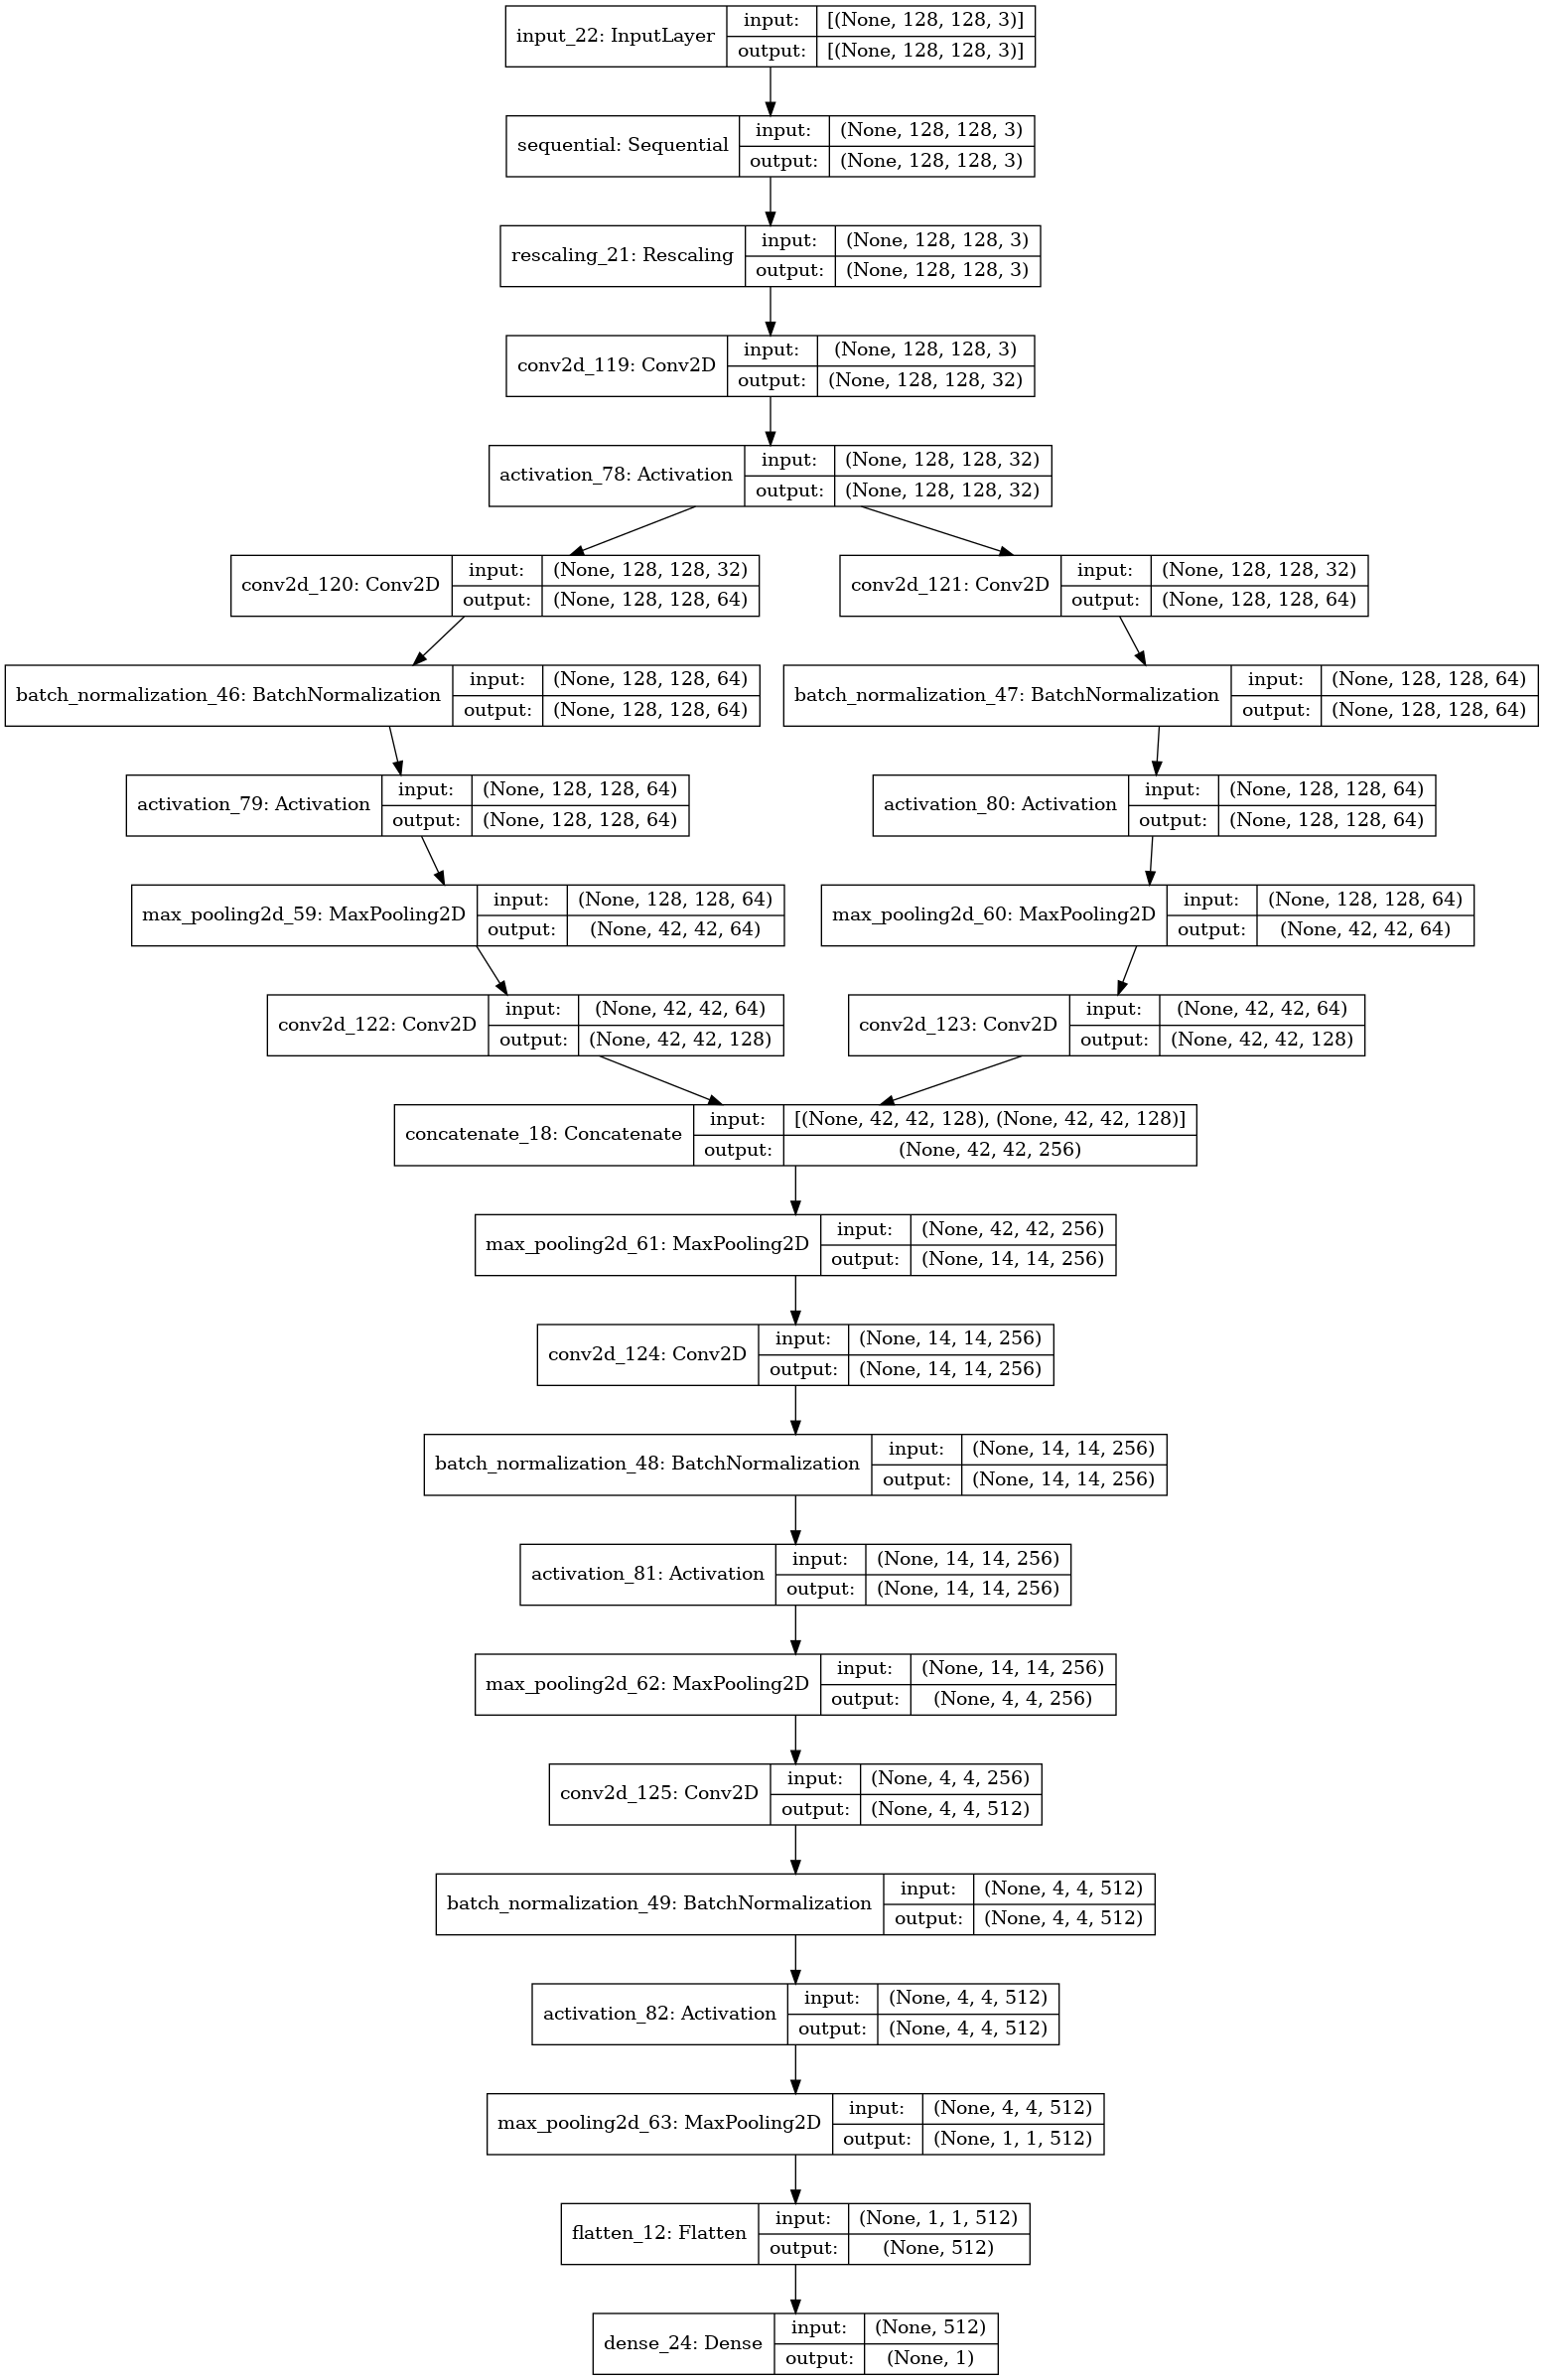

In [91]:
l = [128]
def Net ():
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides=1, padding='same')(x) 
    x = layers.Activation('relu')(x)
    x_1 = layers.Conv2D(64, 3, padding='same')(x) 
    x_2 = layers.Conv2D(64, 3, padding='same')(x)
    for size in l: 
        x_1 = layers.BatchNormalization()(x_1)
        x_1 = layers.Activation('relu')(x_1)
        x_1 = layers.MaxPooling2D(3)(x_1)
        x_1 = layers.Conv2D(size, 3, padding='same')(x_1)
    for size in l: 
        x_2 = layers.BatchNormalization()(x_2)
        x_2 = layers.Activation('relu')(x_2)
        x_2 = layers.MaxPooling2D(3)(x_2)  
        x_2 = layers.Conv2D(size, 3, padding='same')(x_2)
#     for size in l:
#         x_3 = layers.Conv2D(size, 3, padding='same')(x) 
#         x_3 = layers.BatchNormalization()(x_3)
#         x_3 = layers.Activation('tanh')(x_3)
#         x_3 = layers.AveragePooling2D(3)(x_3)
    c = layers.Concatenate(axis=-1)([x_1,x_2])
    c = layers.MaxPooling2D(3)(c)
    c = layers.Conv2D(256,3,padding='same')(c)
    c = layers.BatchNormalization()(c)
    c = layers.Activation('relu')(c)
    c = layers.MaxPooling2D(3)(c)
    c = layers.Conv2D(512,3,padding='same')(c)
    c = layers.BatchNormalization()(c)
    c = layers.Activation('relu')(c)
    c = layers.MaxPooling2D(3)(c)
    c = layers.Flatten()(c)
    outputs = layers.Dense(1, activation = 'sigmoid')(c)
    return keras.Model(inputs, outputs)
model = Net()
keras.utils.plot_model(model, show_shapes=True)

In [92]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 3)  0           input_22[0][0]                   
__________________________________________________________________________________________________
rescaling_21 (Rescaling)        (None, 128, 128, 3)  0           sequential[21][0]                
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 128, 128, 32) 896         rescaling_21[0][0]               
___________________________________________________________________________________________

In [93]:

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# model = keras.Sequential([
#         keras.Input(shape = input_shape),
#         layers.Conv2D(64, kernel_size=(3, 3), activation = 'relu'),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation = 'sigmoid')
# ])

# model.summary()

In [94]:
# history = HistoryCallback()

In [95]:
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="val_loss", # по какому параметру будем останавливать
#     patience=10, # сколько эпох подряд качество не должно улучшаться для остановки
#     restore_best_weights=False # также можно восстанавливать лучшие веса после остановки (откатываться на 5 эпох назад)
# )

In [96]:
batch_size = 32
epochs = 10
model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics='acc')

In [97]:
model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=val_ds)#, callbacks=[history, early_stopping],verbose=1,use_multiprocessing=True)

Epoch 1/10
586/586 [==============================] - 36s 59ms/step - loss: 0.9226 - acc: 0.6001 - val_loss: 0.5724 - val_acc: 0.7067
Epoch 2/10
586/586 [==============================] - 35s 59ms/step - loss: 0.5605 - acc: 0.7123 - val_loss: 0.5646 - val_acc: 0.7226
Epoch 3/10
586/586 [==============================] - 35s 59ms/step - loss: 0.4620 - acc: 0.7836 - val_loss: 0.5267 - val_acc: 0.7320
Epoch 4/10
586/586 [==============================] - 34s 58ms/step - loss: 0.3846 - acc: 0.8255 - val_loss: 0.3888 - val_acc: 0.8279
Epoch 5/10
586/586 [==============================] - 34s 58ms/step - loss: 0.3284 - acc: 0.8557 - val_loss: 0.2905 - val_acc: 0.8706
Epoch 6/10
586/586 [==============================] - 34s 58ms/step - loss: 0.2898 - acc: 0.8743 - val_loss: 0.2430 - val_acc: 0.8998
Epoch 7/10
586/586 [==============================] - 34s 58ms/step - loss: 0.2610 - acc: 0.8879 - val_loss: 0.2717 - val_acc: 0.8834
Epoch 8/10
586/586 [==============================] - 34s 58ms